# AI534 Implementation Assignment 3###

**Deadline**: Sunday, Nov. 19, by 11:59pm

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

In this assignment, you will use the sklearn package to experiment with Support Vector Machines and Naive Bayes models. The experiments will utilize the validation data to perform parameter tuning and explore the impact of different parameters on the models' behavior.

You may modify the starter code as you see fit, including changing existing or adding new code blocks. However, please ensure that your modifications are clear so that your TA can easily understand what you are doing and why.

First let's import the packages needed for this assignment.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

import seaborn as sns


# Data
The data for this assignment consists of a natural language sentiment dataset sourced from Twitter. The first column indicates sentiment of the tweets (zero representing negative sentiment and one for positive sentiment) and the second column contains the text of the tweets.

Two datasets are provided on Canvas: a training set named 'IA3-training.csv' and a validation set named 'IA3-dev.csv'. You will use the training set to build your models and the validation set to tune the parameters and observe their impacts.

Let's load the data.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path   = '/content/gdrive/My Drive/AI534/IA3-dev.csv'   # DO NOT MODIFY THIS. Please make sure your data has this exact path

train_data = pd.read_csv(train_path)
val_data   = pd.read_csv(val_path)

Mounted at /content/gdrive


# Part 0: Preprocessing to form BoW Representation (5 pts)
In this part, you will take the text of the tweets and convert it to the bag-of-words (BoW) representation that can be processed by the model you will train. First, you will build your BoW vocabulary using the training set and represent your training set using *tf-idf*.

Here ***tf*** stands for term frequecy and is defined as follows for a document $d$ and term $t$:

$TF(t,d) = \frac{\mbox{Num. of times } t \mbox{ appears in } d}{\mbox{Total number of terms in }d}$

and ***idf*** stands for inverse document frequency and is defined as follows for a term $t$ and a document collection $D$

$IDF(t, D) = \log(\frac{N}{|\{d\in D: t\in d\}|}) $


where $N$ is the total number of documents in $D$, and $|\{d\in D: t\in d\}|$ is the number of documents that contain term $t$.


Specifically, you will be using the **TfidfVectorizer** class from the sklearn.feature_extraction.text package (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#). For this assignment, you should set '***stop_words=english***', other parameters can remain at their default values.

The specific methods you will need to use include:

*   ***fit_transform()***:  You will apply this function to the training text to learn the vocabulary and the inverse document frequency, and generate the tf-idf representation for the training documents.

*   ***transform()***: you will apply this function to the validation text to generate the tf-idf representation for the validation documents, using a vocabulary and inverse document frequency that are already learned from the training data.

Note that both of the above methods return a sparse matrix representation of the documents. This format can be directly used by the SVM package and the Naive Bayes Package for learning. Using a sparse matrix for your document representation is computationally much more efficient, especially for SVM models.

In [ ]:
# Your code goes here
tweets_train  = train_data['text'].values.tolist()     # Converting all the training tweets into list
tweets_val    = val_data['text'].values.tolist()       # Converting all the valiation tweets into list

vectorizer    = TfidfVectorizer(stop_words='english')  # Creating instance

X_train       = vectorizer.fit_transform(tweets_train) # Creating tf-idf for the training documents
X_val         = vectorizer.transform(tweets_val)       # Generating tf-idf for validation documents

Y_train       = train_data['sentiment'].values         # Sentiments label from training data
Y_val         = val_data['sentiment'].values           # Sentiments label from validation data

**Question**
1. Examine the types of words present in each of the three categories: 'common', 'positive', and 'negative'. Describe the nature and characteristics of these words.
2. Reflect on how a linear classification model might utilize the words from each category. What are your expectations regarding the sign (positive or negative) and magnitude (size) of the weights that would be assigned to these words by the model?

In [ ]:
# Answer 1)
from tqdm import tqdm

all_features = vectorizer.get_feature_names_out()       # bag of words (vocabulary)
tf_idf_score = X_train.data                             # Score of training words

sorted_index  = np.argsort(tf_idf_score)[::-1]          # Arranging the array in decending order
tf_idf_indexs = X_train.indices[sorted_index]

top_positive_word = []
top_negative_word = []

for ind in tqdm(tf_idf_indexs):                         # loop through highest tf-idf score
  word = all_features[ind]

  for ind, X in enumerate(tweets_train):

    if word in X:
      if (Y_train[ind] == 1) and (len(top_positive_word) <= 20):     # if the training label of the collection is positive
        top_positive_word.append(word)
        top_positive_word = list(set(top_positive_word))             # filter redundant words
        break

      elif (Y_train[ind] == 0) and (len(top_negative_word) <= 20):   # if the training label of the collection is negative
        top_negative_word.append(word)
        top_negative_word = list(set(top_negative_word))             # filter redundant words
        break

  if (len(top_positive_word) >= 20) and (len(top_negative_word) >= 20):
    break

print('###Examples from Positive Words###')
print(top_positive_word)

print('###Examples from Negative Words###')
print(top_negative_word)

print('###Examples from Common Words###')
print(set(top_positive_word) - set(set(top_positive_word) - set(top_negative_word))) # Extracting only the common words from both positive and negative words

  0%|          | 58/85371 [00:00<03:18, 428.77it/s]

###Examples from Positive Words###
['pleasure', 'thnx', 'prove', 'cool', 'fuck', 'letting', 'phones', 'smiling', 'suck', 'hate', 'shortly', 'fav', 'appreciated', 'welcome', 'thankyou', 'nope', 'hilarious', 'apology', 'lets', 'respect']
###Examples from Negative Words###
['embarrassing', 'bish', 'hello', 'ticks', 'outta', 'thread', 'fuck', 'xx', 'certainly', 'noooooooooooooooooooooope', 'jetblue', 'hell', 'solution', 'false', 'united', 'southwestair', 'shared', 'dmed', 'wheelchairs', 'usairways', 'americanair']
###Examples from Common Words###
{'fuck'}


**Your answer goes here.**<br>
Answer 1) <br>
Nature and characteristics of these three categories is explained below:<br>
1.  Common words: <br>
This is a netural word which neither provides positive nor negative sentiment in the sentences. They are frequent and widely used in everyday language which essential for constructing sentences and conveying basic meaning but carries no siginificat semantic information. These words are mostly preposition, articles, conjunctions, etc.<br>
Examples from our training data are <b>'is', 'in', 'of', 'there', 'was', 'and, at, etc.</b>

2. Positive words:<br>
Positive words are those that convey a positive sentiment or favorable meaning. These words provides overall positive tone to a piece of text.<br>
Examples from our training data are <b>'great', 'love', 'save', 'thank', 'wonderful', 'hope', 'Nice'.</b>

3. Negative words:
Negative words are those that convey a negative sentiment or unfavorable meaning. These words provides overall negative tone to a piece of text.<br>
Examples from our training data are <b>'Cancelled', 'unacceptable', 'Disappointed', 'error', 'miss'</b>

Answer 2) <br>
If we use the linear classification model and assign positive words as '1' and negative words as '0', then the negative words will have negative weights while positive words will have positive weights. And the strong sentiment words like 'great', 'wonderful', and 'love' that appear mostly in the positive sentiment in the training data will have a higher positive magnitude, while the words like 'disappointed' and 'cancelled' that appear repeatedly in the negative sentiment in the training data will have a higher negative magnitude.

# Part 1. (30 pts) Linear SVM.
Use sklearn to train linear SVMs and tune the hyperparameter $c$ using grid search, considering $c = 10^i$ with $i$ ranging from -3 to 3, based on the validation accuracy. For each $c$ value, please
1. build a linear SVM model using the svm.SVC class
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please produce the following two plots:
1.   Accuracy vs. $c$. In this plot, please plot both the training and validation accuracy as a function of the $c$ parameter (using log scale for $c$)
2.   Number of support vectors vs. $c$. In this plot, please plot the # of total support vectors for your SVM mdoel as a function of the $c$ parameter (using log scale for $c$).

In [109]:
from os import access
# Your code goes here.`
c = 0.001

def evaluate_SVM(c, predict_train=True):
  # Building linear SVM
  svm_model = svm.SVC(kernel='linear', C = c)
  svm_model.fit(X_train, Y_train) # Fitting training data for SVM model

  train_acc = 0.0
  if predict_train:
    # Predict Training accuracy
    Y_train_pred = svm_model.predict(X_train)
    train_acc    = accuracy_score(Y_train, Y_train_pred)

  # Predict Validation accuracy
  Y_val_pred   = svm_model.predict(X_val)
  val_acc      = accuracy_score(Y_val, Y_val_pred)

  return svm_model, train_acc, val_acc

svm_model, train_acc, val_acc = evaluate_SVM(c)                                                           # Build SVM Model
print(f"Number of Support Vectors: {svm_model.support_vectors_.shape[0]}")                                # Record total number of support vectors
print(f"Training Accuracy: {round(train_acc * 100, 4)} | Validation Accuracy: {round(val_acc*100, 4)}")   # Evaluate the model's accuracy on the training data and validation data


Number of Support Vectors: 3697
Training Accuracy: 79.6333 | Validation Accuracy: 79.04


In [111]:
import matplotlib.pyplot as plt
from tqdm import tqdm


# Creating a search grid for tunning hypterparamters c
accuracies_train    = []      # Store training accuracy for different value of c
accuracies_val      = []      # Store validation accuracy for different value of c
num_support_vectors = []      # Store support vectors for different value of c

c_range             = range(-3, 4)

for i in tqdm(c_range):
  c = 10**i

  svm_model, train_acc, val_acc = evaluate_SVM(c)

  accuracies_val.append(val_acc)                      # Store the validation accuracy
  accuracies_train.append(train_acc)                  # Store the training accuracy

  num_support_vectors.append(svm_model.support_vectors_.shape[0]) # Store number of support vectors

100%|██████████| 7/7 [00:59<00:00,  8.53s/it]


Value of c for Max accuracy: 1


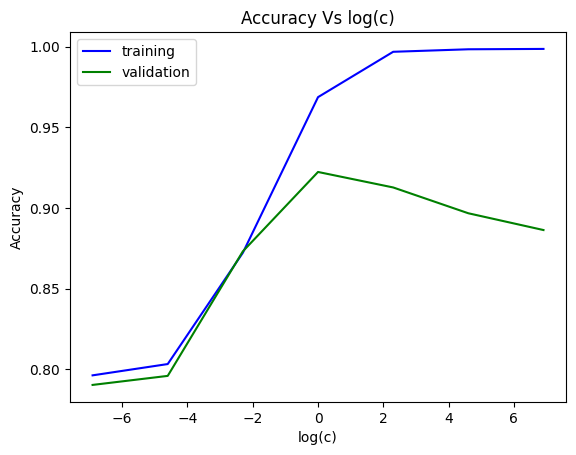

In [112]:
# Plot accuracy vs log(c)for training and validation data
c_all = [10**i for i in c_range]
print(f"Value of c for Max accuracy: {c_all[np.argmax(accuracies_val)]}")

plt.plot(np.log(c_all), accuracies_train, label='training', c='b')
plt.plot(np.log(c_all), accuracies_val, label='validation', c='g')
plt.title("Accuracy Vs log(c)")
plt.xlabel('log(c)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

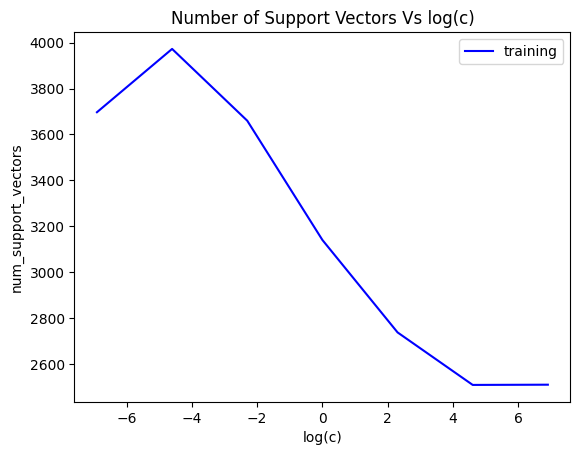

In [113]:
# plot number of support vectors vs log(c)

plt.plot(np.log(c_all), num_support_vectors, label='training', c='b')
plt.title("Number of Support Vectors Vs log(c)")
plt.xlabel('log(c)')
plt.ylabel('num_support_vectors')
plt.legend()
plt.show()

**Question**
1. What trend do you theoretically expect to see for training and validation performance as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?
2. What trend do you theoretically expect to see for the number of support vectors as we increase $c$? Why? Does the observed behavior match your expectation? If not, can you provide some explanation?  

**Your answer goes here**

<b>Answer 1)</b> <br>
<b>Theoretical:</b><br>
Increasing the value of c tries to reduce the misclassification error by fitting each data point, which increases overfitting. Therefore, it increases training performance while generalization of the model decreases, reducing the validation performance of the model.

<b>Practical Output:</b><br>
Yes, our experiment matches our expectations. From the above plots, we can clearly observe that the training accuracy increased with increasing the value of 'c', while the validation accuracy only increased until 'c' equaled zero, after which its accuracy gradually decreased. Validation accuracy increased when the value of log(c) ranged from -6 to 0 because the model was underfitting, neglecting the misclassification error.


<b> Answer 2) </b> <br>
<b> Theoretical:</b>
Increasing the value of c reduces number of support vectors since it tries to fit each training data points, reducing the margin. Reducing the margin reduces number of support vectors.

<b>Practical Output:</b><br>
Yes, our experience matches our theoretical expectations. From the plot between the number of support vectors and log(c), we can clearly see that the number of support vectors linearly increased to around 4000 and gradually decreased below 2600 and remained steady as we increased the value of c.

Expand your search beyond the grid search for the parameter $c$.
Here is the basic instruction:
* **Boundary Expansion**: If the best-performing parameter choice is located at the edge of your current grid search range, extend this boundary outward. This approach helps to explore whether even better-performing parameters exist beyond the existing limits of your grid.

* **Grid Refinement for Central Optima**: When the optimal parameter choice lies within the middle of your search grid, focus on refining the grid around this optimum. For instance, if your current best result is at $i=1$, consider adding intermediate points near the current best such as $i=0.5$ and $1.5$ to your search. This targeted refinement helps in achieving a more precise determination of the optimum within the identified range.

Additionally, it's important to apply these strategies iteratively as needed. If subsequent searches reveal new boundaries or central optima, repeat the expansion or refinement process to continually hone in on the most effective parameters.



In [110]:
# Your code goes here
# Searching in the range of 0.25 to 1.75
import matplotlib.pyplot as plt
from tqdm import tqdm

# Creating a search grid for tunning hypterparamters c
accuracies_train    = []      # Store training accuracy for different value of c
optimal_acc_all     = []      # Store validation accuracy for different value of c
optimal_c_all       = []      # Store optimal value of c
num_support_vectors = []      # Store support vectors for different value of c

min_range           = -3
max_range           = 3
grid_step           = 1

stop_c_val          = 0.00001
prev_acc            = 0.0

num_step            = 0
prev_acc            = 1000

same_acc_count      = 0

while True:
  c_range = np.arange(min_range, max_range, grid_step, dtype=float)
  accuracies_val = []

  for i in tqdm(c_range):

    c = 10**i

    svm_model, train_acc, val_acc = evaluate_SVM(c, predict_train=False)
    accuracies_val.append(val_acc)                      # Store the validation accuracy

  optimal_c   = c_range[np.argmax(accuracies_val)]
  optimal_acc = np.max(accuracies_val)

  num_step += 1

  # calculate new range
  if (optimal_c == c_range[0]):
    min_range += -3 * grid_step
    max_range = optimal_c

  elif (optimal_c == c_range[1]):
    max_range += 3 * grid_step
    min_range = optimal_c

  else:
    grid_step = grid_step / (2*num_step)
    min_range = optimal_c - 3 * grid_step
    max_range = optimal_c + 3 * grid_step


  print(f'min:{min_range}, max:{max_range}, grid_step:{grid_step}, C: {optimal_c} | accuracy: {optimal_acc}')

  same_acc_count = (same_acc_count + 1) if abs(prev_acc - optimal_acc) < 1e-3 else 0

  if same_acc_count > 3:
    break
  prev_acc = optimal_acc

  optimal_acc_all.append(optimal_acc)
  optimal_c_all.append(optimal_c)

ind = np.argmax(optimal_acc_all)
print("Best value of c", 10**(optimal_c_all[ind]), "Best Accuracy: ", optimal_acc_all[ind])

100%|██████████| 6/6 [00:31<00:00,  5.24s/it]


min:-1.5, max:1.5, grid_step:0.5, C: 0.0 | accuracy: 0.9224


100%|██████████| 6/6 [00:29<00:00,  4.83s/it]


min:-0.375, max:0.375, grid_step:0.125, C: 0.0 | accuracy: 0.9224


100%|██████████| 6/6 [00:27<00:00,  4.64s/it]


min:0.1875, max:0.3125, grid_step:0.020833333333333332, C: 0.25 | accuracy: 0.9252


100%|██████████| 6/6 [00:29<00:00,  4.85s/it]


min:0.26302083333333337, max:0.27864583333333337, grid_step:0.0026041666666666665, C: 0.27083333333333337 | accuracy: 0.9256


100%|██████████| 6/6 [00:27<00:00,  4.65s/it]


min:0.25520833333333337, max:0.26302083333333337, grid_step:0.0026041666666666665, C: 0.26302083333333337 | accuracy: 0.9256


100%|██████████| 3/3 [00:14<00:00,  4.86s/it]


min:0.25781250000000006, max:0.27083333333333337, grid_step:0.0026041666666666665, C: 0.25781250000000006 | accuracy: 0.9256


100%|██████████| 5/5 [00:24<00:00,  4.81s/it]

min:0.25000000000000006, max:0.25781250000000006, grid_step:0.0026041666666666665, C: 0.25781250000000006 | accuracy: 0.9256
Best value of c 1.8656635785769125 Best Accuracy:  0.9256


**Question:**
What is the best validation performance you are able to achieve using linear SVM on this dataset? What $c$ value is used?

Answer: The best validation accuracy is 0.9256 using linear SVM on the given dataset. The value of c is 1.8656635785769125

For the best performing linear SVM model that you built, identify and report the ten words with the highest positive weight coefficients and the ten words with the highest negative weight coefficients, separately.

In [ ]:
# Your code goes here
all_features = vectorizer.get_feature_names_out() # Name of the word being trained
print(all_features.shape)
feature_weights = svm_model.coef_.data            # weight coefficient of the words being trained
feature_index   = svm_model.coef_.indices         # feature index respective to weight coefficient

# Calculation of ten words with highest positive weight coefficient
sorted_index          = np.argsort(feature_weights)[::-1][:10] # Fliping to get the decending
sorted_features_index = feature_index[sorted_index]            # Select the top 10 sorted index
sorted_weights        = feature_weights[sorted_index]          # Select the top 10 sorted weights

print("Top ten words with highest positive weight coefficient")
for word, weight in zip(all_features[sorted_features_index], sorted_weights):
  print(f"word: {word} | weight : {weight}")

print("############################################################")
# Calculation of ten words with highest negative weight coefficient
sorted_index          = np.argsort(feature_weights)[:10]
sorted_features_index = feature_index[sorted_index]            # Select the top 10 sorted index
sorted_weights        = feature_weights[sorted_index]          # Select the top 10 sorted weights

print("Top ten words with highest negative weight coefficient")
for word, weight in zip(all_features[sorted_features_index], sorted_weights):
  print(f"word: {word} | weight : {weight}")

(10748,)
Top ten words with highest positive weight coefficient
word: thank | weight : 5.3640505630429285
word: thanks | weight : 4.927407018958909
word: awesome | weight : 3.743383553079377
word: great | weight : 3.613105156826408
word: kudos | weight : 3.4368616416401814
word: love | weight : 3.0957925958680375
word: excellent | weight : 2.9084835730279206
word: amazing | weight : 2.8386753458124017
word: best | weight : 2.694490604218021
word: appreciate | weight : 2.4189915340998533
############################################################
Top ten words with highest negative weight coefficient
word: worst | weight : -3.065378481242382
word: hold | weight : -2.809432570739567
word: hours | weight : -2.6007924587434235
word: hour | weight : -2.3163933122902014
word: website | weight : -2.2812090838530876
word: luggage | weight : -2.205132245106403
word: delayed | weight : -2.132692732027176
word: paid | weight : -1.8709818874773707
word: delay | weight : -1.8156610702566187
word: 

# Part 2. (35 pts) SVM with RBF kernel

Use sklearn to train SVMs with RBF kernel and tune the hyperparameters $c$ and $\gamma$ ($\gamma=1/\sigma^2$ in the RBF kernel definition provided in the lecture slides) using grid search based on the validation accuracy. For $c$, please search over $c = 10^i$ with $i$ ranging from $-3$ to $3$. For $\gamma$, please search over $\gamma=10^{-i}$ with $i$ ranging from -3 to 1.  For each $c$ and $\gamma$ value combination, please
1. build a SVM model using the svm.SVC class with kernel="rbf"
2. record the total number of support vectors of your model
3. evaluate the model's accuracy on the training data and validation data respectively.


Please plot the training accuracy, validation accuracy, and the number of support vectors as function of $c$ and $\gamma$ using the heatmap function from the seaborn package (https://seaborn.pydata.org/generated/seaborn.heatmap.html). Please use 'annot=True' and specify appropriate format to ensure the annotation can be easily read on the heatmap.


In [114]:
# Your code goes here
from os import access
# Your code goes here.`
c = 0.001
gamma = 1

def evaluate_SVM(c, gamma, predict_train=True):
  # Building linear SVM
  svm_model = svm.SVC(kernel='rbf', C = c, gamma=gamma)
  svm_model.fit(X_train, Y_train) # Fitting training data for SVM model

  train_acc = 0.0
  if predict_train:
    # Predict Training accuracy
    Y_train_pred = svm_model.predict(X_train)
    train_acc    = accuracy_score(Y_train, Y_train_pred)

  # Predict Validation accuracy
  Y_val_pred   = svm_model.predict(X_val)
  val_acc      = accuracy_score(Y_val, Y_val_pred)

  return svm_model, train_acc, val_acc

svm_model, train_acc, val_acc = evaluate_SVM(c, gamma)                                                 # 1) build a SVM model using the svm.SVC class with kernel="rbf"
print(f"Number of Support Vectors: {svm_model.support_vectors_.shape[0]}")                             # 2) record the total number of support vectors of your model
print(f"Training Accuracy: {round(train_acc * 100, 4)} | Validation Accuracy: {round(val_acc*100, 4)}")# 3) evaluate the model's accuracy on the training data and validation data respectively


Number of Support Vectors: 3677
Training Accuracy: 79.6333 | Validation Accuracy: 79.04


In [115]:
from tqdm import tqdm

# Creating a search grid for tunning hypterparamters c
accuracies_train    = []      # Store training accuracy for different value of c
accuracies_val      = []      # Store validation accuracy for different value of c
num_support_vectors = []      # Store support vectors for different value of c

c_ranges            = range(-3, 4)
lambda_ranges       = range(-3, 2)

for ind_i, i in tqdm(enumerate(c_ranges)):
  c = 10**i
  accuracies_val.append([])
  accuracies_train.append([])
  num_support_vectors.append([])

  for ind_j, j in tqdm(enumerate(lambda_ranges)):

    gamma  = 10**(-j)
    svm_model, train_acc, val_acc = evaluate_SVM(c, gamma)

    accuracies_val[ind_i].append(val_acc)                                    # Store the validation accuracy
    accuracies_train[ind_i].append(train_acc)                                # Store the training accuracy
    num_support_vectors[ind_i].append(svm_model.support_vectors_.shape[0])   # Store number of support vectors

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:09,  9.54s/it]
2it [00:18,  9.43s/it]
3it [00:28,  9.70s/it]
4it [00:37,  9.36s/it]
5it [00:48,  9.69s/it]
1it [00:48, 48.45s/it]
0it [00:00, ?it/s]
1it [00:08,  8.35s/it]
2it [00:18,  9.51s/it]
3it [00:27,  9.35s/it]
4it [00:40, 10.82s/it]
5it [01:19, 15.91s/it]
2it [02:08, 66.76s/it]
0it [00:00, ?it/s]
1it [00:10, 10.76s/it]
2it [00:25, 13.20s/it]
3it [00:36, 11.91s/it]
4it [00:49, 12.52s/it]
5it [01:21, 16.37s/it]
3it [03:29, 73.66s/it]
0it [00:00, ?it/s]
1it [00:08,  8.81s/it]
2it [00:19, 10.21s/it]
3it [00:29,  9.98s/it]
4it [00:43, 11.44s/it]
5it [01:19, 15.99s/it]
4it [04:49, 76.15s/it]
0it [00:00, ?it/s]
1it [00:11, 11.20s/it]
2it [00:20, 10.18s/it]
3it [00:30,  9.98s/it]
4it [00:49, 13.50s/it]
5it [01:43, 20.62s/it]
5it [06:33, 85.88s/it]
0it [00:00, ?it/s]
1it [00:10, 10.60s/it]
2it [00:18,  9.27s/it]
3it [00:29,  9.99s/it]
4it [00:49, 13.64s/it]
5it [01:42, 20.54s/it]
6it [08:15, 91.60s/it]
0it [00:00, ?it/s]
1it [00:08,  8.86s/i

In [116]:
accuracies_train
accuracies_val
num_support_vectors

[[3666, 3666, 3666, 3677, 3745],
 [3666, 3666, 3818, 4645, 8937],
 [3666, 3816, 4033, 4666, 8937],
 [3819, 3992, 3596, 4803, 8866],
 [3989, 3499, 3246, 5264, 8821],
 [3494, 3059, 3179, 5264, 8821],
 [3044, 2734, 3213, 5264, 8821]]

[Text(0.5, 23.52222222222222, 'lamda'), Text(50.722222222222214, 0.5, 'c')]

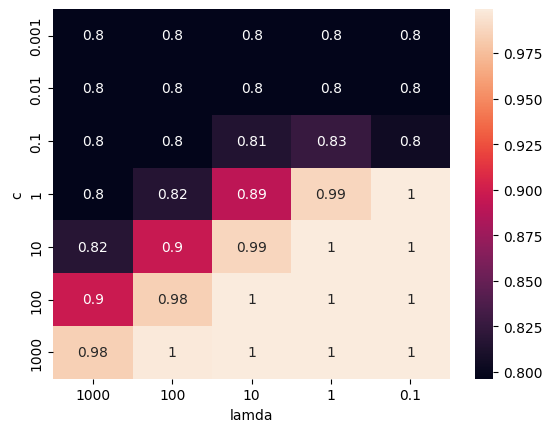

In [117]:
import seaborn as sns

c_ranges            = [10**i for i in range(-3, 4)]
lambda_ranges       = [10**(-i)for i in range(-3, 2)]

ax = sns.heatmap(accuracies_train, annot=True, xticklabels = lambda_ranges, yticklabels = c_ranges)
ax.set(xlabel="lamda", ylabel="c")

[Text(0.5, 23.52222222222222, 'lamda'), Text(50.722222222222214, 0.5, 'c')]

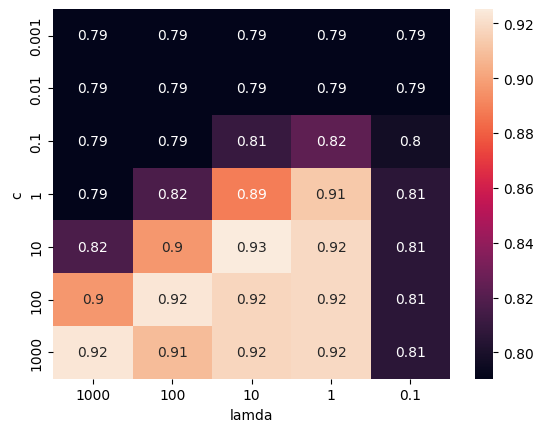

In [118]:
import seaborn as sns

c_ranges            = [10**i for i in range(-3, 4)]
lambda_ranges       = [10**(-i)for i in range(-3, 2)]

ax = sns.heatmap(accuracies_val, annot=True, xticklabels = lambda_ranges, yticklabels = c_ranges)
ax.set(xlabel="lamda", ylabel="c")

[Text(0.5, 23.52222222222222, 'lamda'), Text(50.722222222222214, 0.5, 'c')]

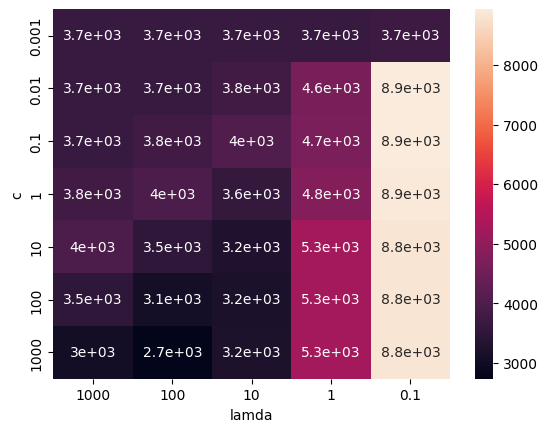

In [119]:
import seaborn as sns

c_ranges            = [10**i for i in range(-3, 4)]
lambda_ranges       = [10**(-i)for i in range(-3, 2)]

ax = sns.heatmap(num_support_vectors, annot=True, xticklabels = lambda_ranges, yticklabels = c_ranges)
ax.set(xlabel="lamda", ylabel="c")

**Question**
1. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ to influence the model's ability to overfit to the training data? Based on this perspective, how would you expect the training accuracy to change as you change $c$ (keeping $\gamma$ constant), and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, provide some possible explanations for the discrepancies.

2. Similarly, how would you expect the validation accuracy to change as you change $c$ (keeping $\gamma$ constant) and as you change $\gamma$ (keeping $c$ constant)? Are there any discrepancies between the expected and observed trends? If so, please provide some possible explanations for the differences.

3. From a theoretical perspective, how would you expect the parameters $c$ and $\gamma$ influence the number of support vectors? Are there any discrepencies between the expected and observed trends?  If so, provide some possible explanations for the differences.

**Your answer goes here**


1. Influence on Training Accuracy:

 Higher values of C allow the model to classify more training points correctly, potentially leading to overfitting as it becomes more sensitive to individual data points.
  The parameter $\gamma$ in the RBF kernel controls the shape of the decision boundary. Larger values of $\gamma$ lead to a more complex decision boundary, which might overfit the training data.
  Increasing c (keeping $\gamma$ constant) should, increase the training accuracy as the model becomes more sensitive to individual data points. Similarly, increasing $\gamma$ (keeping c constant) should also increase training accuracy because it allows the model to create a more complex decision boundary.
  The observed trend of increasing training accuracy with increasing C aligns with expectations.
  The observed trend of increasing training accuracy with increasing $\gamma$ also aligns with expectations.
  

  2. Influence on Validation Accuracy:

  Increasing c (keeping $\gamma$ constant) should, increase the validation accuracy as the model becomes better at predicting the data but will likely decrease at larger values as it overfits on the training data. Similarly, increasing $\gamma$ (keeping c constant) should also increase training validation because as it creates more complex decision boundary but this too will overfit on the training data at larger values.
  This fits the observed data, we see a general increase in training data for increases in c and $\gamma$ that decreases again at larger values.

3. Influence on Number of Support Vectors:
Higher values of c should lead to fewer support vectors as the model becomes more focused on correctly classifying each training example. A larger $\gamma$ should result in more support vectors as it creates a more complex decision boundary.
This mostly fits the overved data. We see some deviation ar lerger values, for example, for the largest value of $\gamma$, we see that as c increases the number of support vectors increases instead of decreasnig as expected. THis is likely due to complex interactions between c and $\gamma$, In this case it is likely that the increaded complexity of the decision boundary benefited from more support vectors despite the higher penalty.

Expand your search using the strategy introduced in part 1 to search for the $c$ and $\gamma$ values that leads to the highest validation accuracy on this data set. Please report the best validation accuracy you achieve and the corresponding $c$ and $\gamma$ values used.

In [74]:
# Your code goes here

import matplotlib.pyplot as plt
from tqdm import tqdm

# This function calculates the best value of gamma through looping
def find_best_gamma(c, min_range_gamma, max_range_gamma, grid_step_gamma, num_step_gamma, prev_acc_gamma, same_acc_count_gamma):
  # Loop until you find the best gamma value
  while True:
    gamma_range          = np.arange(min_range_gamma, max_range_gamma, grid_step_gamma, dtype=float)
    accuracies_val_gamma = []

    for g in (gamma_range):
      gamma = 10**(-g)
      svm_model, train_acc, val_acc = evaluate_SVM(c, gamma, predict_train=False)
      accuracies_val_gamma.append(val_acc)               # Store the validation accuracy

    optimal_gamma   = gamma_range[np.argmax(accuracies_val_gamma)]
    optimal_acc     = np.max(accuracies_val_gamma)

    num_step_gamma += 1

    print(f'min:{10**(-min_range_gamma)}, max:{10**(-max_range_gamma)}, grid_step:{grid_step_gamma}, gamma: {10**(-optimal_gamma)} | accuracy: {optimal_acc}')

    # calculate new range
    if (optimal_gamma == gamma_range[0]):
      min_range_gamma = optimal_gamma -1 * grid_step_gamma
      max_range_gamma = optimal_gamma

    elif (optimal_gamma == gamma_range[1]):
      max_range_gamma = optimal_gamma + 1 * grid_step_gamma
      min_range_gamma = optimal_gamma

    else:
      grid_step_gamma = grid_step_gamma / (2*num_step_gamma)
      min_range_gamma = optimal_gamma - 2 * grid_step_gamma
      max_range_gamma = optimal_gamma + 2 * grid_step_gamma


    same_acc_count_gamma = (same_acc_count_gamma + 1) if abs(prev_acc_gamma - optimal_acc) < 1e-4 else 0

    if same_acc_count_gamma > 2:                           # Break the loop if the accuracy doesn't changes
      break

    prev_acc_gamma = optimal_acc

    optimal_acc_gamma_all.append(optimal_acc)
    optimal_gamma_all.append(optimal_gamma)

  ind        = np.argmax(optimal_acc_gamma_all)
  best_gamma = optimal_gamma_all[ind]
  best_acc   = optimal_acc_gamma_all[ind]

  return best_gamma, best_acc


In [99]:
# This function calculates the best value of c through looping
def find_best_c(gamma, min_range_c, max_range_c, grid_step_c, num_step_c, prev_acc_c, same_acc_count_c):
  # Loop until you find the best gamma value
  while True:
    c_range          = np.arange(min_range_c, max_range_c, grid_step_c, dtype=float)
    accuracies_val_c = []

    for c in tqdm(c_range):
      c = 10**(c)
      svm_model, train_acc, val_acc = evaluate_SVM(c, gamma, predict_train=False)
      accuracies_val_c.append(val_acc)               # Store the validation accuracy

    optimal_c   = c_range[np.argmax(accuracies_val_c)]
    optimal_acc = np.max(accuracies_val_c)

    num_step_c += 1

    print(f'min:{10**(min_range_c)}, max:{10**(max_range_c)}, grid_step:{grid_step_c}, c: {10**(optimal_c)} | accuracy: {optimal_acc}')

    # calculate new range
    if (optimal_c == c_range[0]):
      min_range_c = optimal_c - 1 * grid_step_c
      max_range_c = optimal_c

    elif (optimal_c == c_range[1]):
      max_range_c = optimal_c + 1 * grid_step_c
      min_range_c = optimal_c

    else:
      grid_step_c = grid_step_c / (2*num_step_c)
      min_range_c = optimal_c - 2 * grid_step_c
      max_range_c = optimal_c + 2 * grid_step_c


    same_acc_count_c = (same_acc_count_c + 1) if abs(prev_acc_c - optimal_acc) < 1e-4 else 0

    if same_acc_count_c > 2:                           # Break the loop if the accuracy doesn't changes
      break

    prev_acc_c = optimal_acc

    optimal_acc_c_all.append(optimal_acc)
    optimal_c_all.append(optimal_c)

  ind        = np.argmax(optimal_acc_c_all)
  best_c     = optimal_c_all[ind]
  best_acc   = optimal_acc_c_all[ind]

  return best_c, best_acc

In [76]:
# Finding the best value of gamma for different value of c (best pairr of c and gamma)
c_ranges            = range(-3, 4)
lambda_ranges       = range(-3, 2)

best_gammas = []
best_accs   = []
best_cs     = []

for i in tqdm(c_ranges):
  c = 10**i

  print("C", c)
  # Creating a search grid for tunning hypterparamters gamma
  accuracies_train          = []      # Store training accuracy for different value of gamma
  optimal_acc_gamma_all     = []      # Store validation accuracy for different value of gamma
  optimal_gamma_all         = []      # Store optimal value of gamma
  num_support_vectors       = []      # Store support vectors for different value of gamma

  min_range_gamma        = -3
  max_range_gamma        = 2

  grid_step_gamma        = 1

  prev_acc               = 0.0

  num_step_gamma         = 0
  prev_acc_gamma         = 1000

  same_acc_count_gamma   = 0

  best_gamma, best_acc = find_best_gamma(c, min_range_gamma, max_range_gamma, grid_step_gamma, num_step_gamma, prev_acc_gamma, same_acc_count_gamma)

  best_gammas.append(best_gamma)
  best_accs.append(best_acc)
  best_cs.append(c)



  0%|          | 0/7 [00:00<?, ?it/s]

C 0.001
min:1000, max:0.01, grid_step:1, gamma: 1000.0 | accuracy: 0.7904
min:10000.0, max:1000.0, grid_step:1, gamma: 10000.0 | accuracy: 0.7904
min:100000.0, max:10000.0, grid_step:1, gamma: 100000.0 | accuracy: 0.7904


 14%|█▍        | 1/7 [01:00<06:04, 60.76s/it]

min:1000000.0, max:100000.0, grid_step:1, gamma: 1000000.0 | accuracy: 0.7904
C 0.01
min:1000, max:0.01, grid_step:1, gamma: 1000.0 | accuracy: 0.7904
min:10000.0, max:1000.0, grid_step:1, gamma: 10000.0 | accuracy: 0.7904
min:100000.0, max:10000.0, grid_step:1, gamma: 100000.0 | accuracy: 0.7904


 29%|██▊       | 2/7 [02:49<07:23, 88.74s/it]

min:1000000.0, max:100000.0, grid_step:1, gamma: 1000000.0 | accuracy: 0.7904
C 0.1
min:1000, max:0.01, grid_step:1, gamma: 1.0 | accuracy: 0.8232
min:10.0, max:0.1, grid_step:0.5, gamma: 0.31622776601683794 | accuracy: 0.8248
min:0.5623413251903491, max:0.1778279410038923, grid_step:0.125, gamma: 0.5623413251903491 | accuracy: 0.8288
min:0.7498942093324559, max:0.5623413251903491, grid_step:0.125, gamma: 0.7498942093324559 | accuracy: 0.828
min:1.0, max:0.7498942093324559, grid_step:0.125, gamma: 1.0 | accuracy: 0.8232
min:1.333521432163324, max:1.0, grid_step:0.125, gamma: 1.333521432163324 | accuracy: 0.8148
min:1.7782794100389228, max:1.333521432163324, grid_step:0.125, gamma: 1.7782794100389228 | accuracy: 0.808
min:2.371373705661655, max:1.7782794100389228, grid_step:0.125, gamma: 2.371373705661655 | accuracy: 0.8036
min:3.1622776601683795, max:2.371373705661655, grid_step:0.125, gamma: 3.1622776601683795 | accuracy: 0.802
min:4.216965034285822, max:3.1622776601683795, grid_step:

 43%|████▎     | 3/7 [09:50<16:03, 240.85s/it]

min:17.78279410038923, max:13.33521432163324, grid_step:0.125, gamma: 17.78279410038923 | accuracy: 0.7972
C 1
min:1000, max:0.01, grid_step:1, gamma: 1.0 | accuracy: 0.9128
min:10.0, max:0.1, grid_step:0.5, gamma: 1.0 | accuracy: 0.9128
min:1.7782794100389228, max:0.5623413251903491, grid_step:0.125, gamma: 0.7498942093324559 | accuracy: 0.9144
min:0.8254041852680184, max:0.6812920690579612, grid_step:0.020833333333333332, gamma: 0.7498942093324559 | accuracy: 0.9144
min:0.7589415559523426, max:0.7409547161832591, grid_step:0.0026041666666666665, gamma: 0.754404319997192 | accuracy: 0.9144


 57%|█████▋    | 4/7 [14:38<12:58, 259.36s/it]

min:0.754404319997192, max:0.7498942093324559, grid_step:0.0026041666666666665, gamma: 0.754404319997192 | accuracy: 0.9144
C 10
min:1000, max:0.01, grid_step:1, gamma: 0.1 | accuracy: 0.9252
min:1.0, max:0.01, grid_step:0.5, gamma: 0.31622776601683794 | accuracy: 0.926
min:0.31622776601683794, max:0.1, grid_step:0.5, gamma: 0.31622776601683794 | accuracy: 0.926
min:1.0, max:0.31622776601683794, grid_step:0.5, gamma: 1.0 | accuracy: 0.9188
min:3.1622776601683795, max:1.0, grid_step:0.5, gamma: 3.1622776601683795 | accuracy: 0.8356
min:10.0, max:3.1622776601683795, grid_step:0.5, gamma: 10.0 | accuracy: 0.806
min:31.622776601683793, max:10.0, grid_step:0.5, gamma: 31.622776601683793 | accuracy: 0.8052
min:100.0, max:31.622776601683793, grid_step:0.5, gamma: 100.0 | accuracy: 0.8052
min:316.22776601683796, max:100.0, grid_step:0.5, gamma: 316.22776601683796 | accuracy: 0.8052


 71%|███████▏  | 5/7 [23:15<11:44, 352.03s/it]

min:1000.0, max:316.22776601683796, grid_step:0.5, gamma: 1000.0 | accuracy: 0.8052
C 100
min:1000, max:0.01, grid_step:1, gamma: 1.0 | accuracy: 0.9188
min:10.0, max:0.1, grid_step:0.5, gamma: 0.31622776601683794 | accuracy: 0.9228
min:0.5623413251903491, max:0.1778279410038923, grid_step:0.125, gamma: 0.4216965034285822 | accuracy: 0.9256
min:0.4216965034285822, max:0.31622776601683794, grid_step:0.125, gamma: 0.4216965034285822 | accuracy: 0.9256
min:0.5623413251903491, max:0.4216965034285822, grid_step:0.125, gamma: 0.5623413251903491 | accuracy: 0.924
min:0.7498942093324559, max:0.5623413251903491, grid_step:0.125, gamma: 0.7498942093324559 | accuracy: 0.9228
min:1.0, max:0.7498942093324559, grid_step:0.125, gamma: 1.0 | accuracy: 0.9188
min:1.333521432163324, max:1.0, grid_step:0.125, gamma: 1.333521432163324 | accuracy: 0.9132
min:1.7782794100389228, max:1.333521432163324, grid_step:0.125, gamma: 1.7782794100389228 | accuracy: 0.9076
min:2.371373705661655, max:1.7782794100389228

 71%|███████▏  | 5/7 [34:24<13:45, 412.82s/it]


KeyboardInterrupt: ignored

In [105]:

ind        = np.argmax(best_accs)
best_c     = best_cs[ind]
best_gamma = 10**(-best_gammas[ind])

print('Best c:', best_c, 'Best Gamma', best_gamma, 'Best accuracy:',  best_accs[ind])

Best c: 10 Best Gamma 0.31622776601683794 Best accuracy: 0.926


In [106]:
# Expanding the space for c to find the best value of c provided best value of gamma
accuracies_train     = []      # Store training accuracy for different value of gamma
optimal_acc_c_all    = []      # Store validation accuracy for different value of gamma
optimal_c_all        = []      # Store optimal value of gamma
num_support_vectors  = []      # Store support vectors for different value of gamma

min_range_c        = np.log10(best_c) - 1
max_range_c        = np.log10(best_c) + 1

grid_step_c        = 0.5

num_step_c         = 0
prev_acc_c         = 1000

same_acc_count_c   = 0

best_c, best_acc = find_best_c(best_gamma, min_range_c, max_range_c, grid_step_c, num_step_c, prev_acc_c, same_acc_count_c)
print("Best fine tune value of c: ", 10**(best_c), "best fine tuned gamma:", best_gamma, "Best accuracy:", best_acc)


100%|██████████| 4/4 [00:27<00:00,  6.95s/it]


min:1.0, max:100.0, grid_step:0.5, c: 3.1622776601683795 | accuracy: 0.9264


100%|██████████| 1/1 [00:07<00:00,  7.05s/it]


min:3.1622776601683795, max:10.0, grid_step:0.5, c: 3.1622776601683795 | accuracy: 0.9264


100%|██████████| 1/1 [00:05<00:00,  5.64s/it]


min:1.0, max:3.1622776601683795, grid_step:0.5, c: 1.0 | accuracy: 0.9108


100%|██████████| 1/1 [00:05<00:00,  5.41s/it]


min:0.31622776601683794, max:1.0, grid_step:0.5, c: 0.31622776601683794 | accuracy: 0.8764


100%|██████████| 1/1 [00:06<00:00,  6.78s/it]


min:0.1, max:0.31622776601683794, grid_step:0.5, c: 0.1 | accuracy: 0.8248


100%|██████████| 1/1 [00:05<00:00,  5.85s/it]


min:0.03162277660168379, max:0.1, grid_step:0.5, c: 0.03162277660168379 | accuracy: 0.7976


100%|██████████| 1/1 [00:05<00:00,  5.40s/it]


min:0.01, max:0.03162277660168379, grid_step:0.5, c: 0.01 | accuracy: 0.7904


100%|██████████| 1/1 [00:06<00:00,  6.14s/it]


min:0.0031622776601683794, max:0.01, grid_step:0.5, c: 0.0031622776601683794 | accuracy: 0.7904


100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


min:0.001, max:0.0031622776601683794, grid_step:0.5, c: 0.001 | accuracy: 0.7904


100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

min:0.00031622776601683794, max:0.001, grid_step:0.5, c: 0.00031622776601683794 | accuracy: 0.7904
Best fine tune value of c:  3.1622776601683795 best fine tuned gamma: 0.31622776601683794 Best accuracy: 0.9264


Therefore, the best value of c is 3.1622776601683795 and gamma is 0.31622776601683794, accuracy: 0.9264

# Part 3: (30 pts) Naive Bayes Classifier

In this part, you will use the same TF-IDF representation of the documents and experiment with MultiNomial Naive Bayes classifier to tune the smoothing parameter $\alpha$. Please consider the following initial values for $\alpha$: [2, 1, 0.5, 0.1, 0.05, 0.01]

For each of the $\alpha$ value, please
1. build a multinomial Naive Bayes model using the MultinomialNB class in the sklearn.naive_bayes package
2. evaluate the model's accuracy on the training data and validation data respectively.

For results, please
1. plot the training and validation accuracy as a function of $\alpha$ (using log scale).
2. print out the best training accuracy with its corresponding $\alpha$ and the best validation accuracy with its corresponding $\alpha$.

alpha: 2 | Training accuracy : 0.8247777777777778 | Validation accuracy : 0.812
alpha: 1 | Training accuracy : 0.8728888888888889 | Validation accuracy : 0.8332
alpha: 0.5 | Training accuracy : 0.9215555555555556 | Validation accuracy : 0.8604
alpha: 0.1 | Training accuracy : 0.9617777777777777 | Validation accuracy : 0.8892
alpha: 0.05 | Training accuracy : 0.9664444444444444 | Validation accuracy : 0.8892
alpha: 0.01 | Training accuracy : 0.9717777777777777 | Validation accuracy : 0.8848


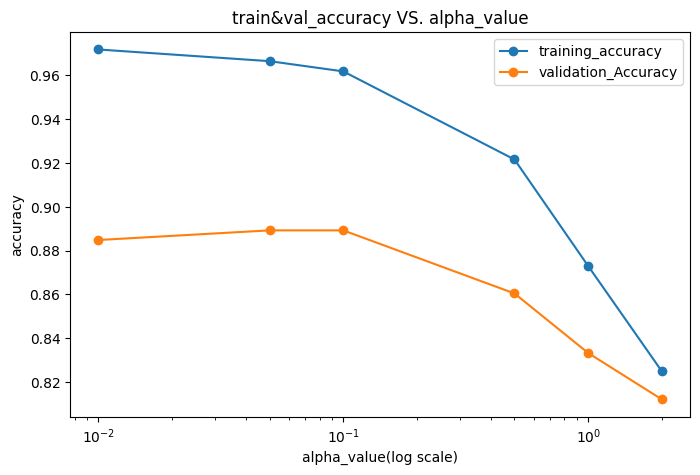

best train alpha: 0.01
best train accuracy: 0.9717777777777777
best validation alpha: 0.1
best validation accuracy: 0.8892


In [ ]:
# Your code goes here.
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

# Alpha values
alpha_values = [2, 1, 0.5, 0.1, 0.05, 0.01]

#Store accuracies
train_acs = []
val_acs   = []

# Models for alpha_values
for a in alpha_values:
    # 1) build a multinomial Naive Bayes model using the MultinomialNB class in the sklearn.naive_bayes package
    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, Y_train)

    # prediction and accuracy of training data
    y_train_pred   = nb_model.predict(X_train)
    train_accuracy = accuracy_score(Y_train, y_train_pred)
    train_acs.append(train_accuracy)

    # prediction and accuracy of validation data
    y_val_pred   = nb_model.predict(X_val)
    val_accuracy = accuracy_score(Y_val, y_val_pred)
    val_acs.append(val_accuracy)

    # 2) Evaluate the model's accuracy on the training data and validation data respectively.
    print(f"alpha: {a} | Training accuracy : {train_accuracy} | Validation accuracy : {val_accuracy}")


#1) plot the training and validation accuracy as a function of  𝛼  (using log scale).
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, train_acs, marker='o', label='training_accuracy')
plt.plot(alpha_values, val_acs, marker='o', label='validation_Accuracy')
plt.xscale('log')
plt.xlabel('alpha_value(log scale)')
plt.ylabel('accuracy')
plt.legend()
plt.title('train&val_accuracy VS. alpha_value')
plt.show()

# print out the best training accuracy with its corresponding  𝛼  and the best validation accuracy with its corresponding  𝛼 .
best_train_a   = alpha_values[np.argmax(train_acs)]
best_val_a     = alpha_values[np.argmax(val_acs)]
best_train_acy = max(train_acs)
best_val_acy   = max(val_acs)

print('best train alpha:', best_train_a,)
print('best train accuracy:',best_train_acy)
print('best validation alpha:',best_val_a)
print('best validation accuracy:', best_val_acy)


**Question**
Theoretically, how do you expect changing the $\alpha$ parameter influence overfitting for Naive Bayes model?
Based on this perspective, how do you expect the training and validation accuracy to change as we change $\alpha$? Are there any discrepancies between the expected and observed trends? If so, can you propose some possible explanations for these differences?

**Your answer goes here**

Theoretically, alpha plays an important role in handling zero probabilities in the dataset. Higher alpha has more smooothing and reduces impact of individual features. This helps the model to reduce overfitting and be less sensitive to the noise in the training data. Smaller alpha has less smoothing. The model is more influenced by the frequencies of each feature in the training data. When decreasing alpha can improve training accuracy, but it may lead to overfitting. The model will become too sensitive. Consequently, the expectation of training accuracy and validation accuracy will increase when alpha decease generally. During the decreasing alpha, the validation accuracy will climb to reach a peak and then gets overfitting and decreases.

The results of the experiment show that the training accuracy increased when the value of alpha decreased, which aligns with the theoretical expectations. For validation accuracy, it increased gradually until an optimal point at log($\alpha$) = 0.1, then it started declining when the value of alpha was further increased. This happened because increasing the value of alpha decreased the overfitting, incresing the generalization capacity of the model but the larger value of alpha highly inglected individual features so the model was underfitted. In addition, it could be due to factors such as bias in the training set, the complexity and noise in the data, or violations of Naive Bayes' independence assumption between features. Moreover, the size and diversity of the dataset may not capture the full range of variations expected in real-world data and may affect the accuracy.

Expand your search using the strategy introduced in part 1 to search for the $\alpha$ that leads to the highest validation accuracy on this data set.
Please report the best validation accuracy you achieve and the corresponding $\alpha$ value used.

In [ ]:
# Your code goes here

import matplotlib.pyplot as plt
from tqdm import tqdm

# Creating a search grid for tunning hypterparamters alpha
accuracies_train    = []      # Store training accuracy for different value of alpha
optimal_acc_all     = []      # Store validation accuracy for different value of alpha
optimal_alpha_all   = []      # Store optimal value of alpha
num_support_vectors = []      # Store support vectors for different value of alpha

min_range           = 0.01
max_range           = 2
grid_step           = 0.05

prev_acc            = 0.0

num_step            = 0
prev_acc            = 1000

same_acc_count      = 0


while True:
  alpha_range = np.arange(min_range, max_range, grid_step, dtype=float)
  accuracies_val = []

  for a in tqdm(alpha_range):

    nb_model = MultinomialNB(alpha=a)
    nb_model.fit(X_train, Y_train)

    # prediction and accuracy of validation data
    y_val_pred   = nb_model.predict(X_val)
    val_accuracy = accuracy_score(Y_val, y_val_pred)
    accuracies_val.append(val_accuracy)               # Store the validation accuracy

  optimal_alpha   = alpha_range[np.argmax(accuracies_val)]
  optimal_acc     = np.max(accuracies_val)

  num_step += 1

  print(f'min:{min_range}, max:{max_range}, grid_step:{grid_step}, Alpha: {optimal_alpha} | accuracy: {optimal_acc}')

  # calculate new range
  if (optimal_alpha == alpha_range[0]):
    min_range = optimal_alpha -3 * grid_step
    max_range = optimal_alpha

  elif (optimal_alpha == alpha_range[1]):
    max_range = optimal_alpha + 3 * grid_step
    min_range = optimal_alpha

  else:
    grid_step = grid_step / (10*num_step)
    min_range = optimal_alpha - 3 * grid_step
    max_range = optimal_alpha + 3 * grid_step


  same_acc_count = (same_acc_count + 1) if abs(prev_acc - optimal_acc) < 1e-4 else 0

  if same_acc_count > 4:                           # Break the loop if the accuracy doesn't changes
    break
  prev_acc = optimal_acc

  optimal_acc_all.append(optimal_acc)
  optimal_alpha_all.append(optimal_alpha)

ind        = np.argmax(optimal_acc_all)
best_alpha = optimal_alpha_all[ind]
print("Best value of alpha", best_alpha, "Best Accuracy: ", optimal_acc_all[ind])


100%|██████████| 40/40 [00:00<00:00, 67.10it/s]


min:0.01, max:2, grid_step:0.05, Alpha: 0.11 | accuracy: 0.8892


100%|██████████| 6/6 [00:00<00:00, 109.37it/s]


min:0.095, max:0.125, grid_step:0.005, Alpha: 0.095 | accuracy: 0.8892


100%|██████████| 3/3 [00:00<00:00, 56.12it/s]


min:0.08, max:0.095, grid_step:0.005, Alpha: 0.08 | accuracy: 0.8904


100%|██████████| 3/3 [00:00<00:00, 54.59it/s]


min:0.065, max:0.08, grid_step:0.005, Alpha: 0.07500000000000001 | accuracy: 0.8908


100%|██████████| 7/7 [00:00<00:00, 50.85it/s]


min:0.07462500000000001, max:0.07537500000000001, grid_step:0.000125, Alpha: 0.07462500000000001 | accuracy: 0.8908


100%|██████████| 4/4 [00:00<00:00, 68.65it/s]


min:0.07425000000000001, max:0.07462500000000001, grid_step:0.000125, Alpha: 0.07425000000000001 | accuracy: 0.8908


100%|██████████| 4/4 [00:00<00:00, 64.25it/s]


min:0.07387500000000001, max:0.07425000000000001, grid_step:0.000125, Alpha: 0.07387500000000001 | accuracy: 0.8908


100%|██████████| 4/4 [00:00<00:00, 70.80it/s]


min:0.07350000000000001, max:0.07387500000000001, grid_step:0.000125, Alpha: 0.07350000000000001 | accuracy: 0.8908


100%|██████████| 4/4 [00:00<00:00, 66.12it/s]

min:0.07312500000000001, max:0.07350000000000001, grid_step:0.000125, Alpha: 0.07312500000000001 | accuracy: 0.8908
Best value of alpha 0.07500000000000001 Best Accuracy:  0.8908


As discussed in class, the multinomial naive bayes classifier learns a linear classifier where the weight coeffcient for each word $i$ can be computed as follows:

$\log P(w_i|y=1) - \log P(w_i|y=0)$

where $P(w_i|y=\cdot)$ denotes the probability for word $i$ when $y=\cdot$

Examine two naive bayes models: one with $\alpha =1$, the other with the best $\alpha$ you identified above. For each model, sort the words based on their weight coefficients. Identify and list the top 10 words along with their corresponding weights, focusing on those with the highest positive weights and the highest negative weights for each model.

In [ ]:
#your code goes here
def get_words(model, feature_name, n=10):

    log_p = model.feature_log_prob_[1] - model.feature_log_prob_[0]
    indice = np.argsort(log_p)
    pwords = []
    for i in range(-n, 0):
      index = indice[i]
      word = feature_name[index]
      weight = log_p[index]
      pwords.append((word, weight))
    pwords.reverse()

    nwords = []
    for i in range(n):
      index = indice[i]
      word = feature_name[index]
      weight = log_p[index]
      nwords.append((word, weight))


    return pwords, nwords

fn              = vectorizer.get_feature_names_out()
model_alpha_1   = MultinomialNB(alpha=1).fit(X_train, Y_train)
model_opt_alpha = MultinomialNB(alpha=best_alpha).fit(X_train, Y_train)

#get the words
alpha_1_words = get_words(model_alpha_1, fn)
alpha_opt_words = get_words(model_opt_alpha, fn)
print('alpha = 1, 10 positive words:', alpha_1_words[0])
print('alpha = 1, 10 negative words:', alpha_1_words[1])
print('best alpha, 10 positive words:', alpha_opt_words[0])
print('best alpha, 10 negative words:', alpha_opt_words[1])

alpha = 1, 10 positive words: [('thank', 2.8844084732627095), ('awesome', 2.4953873957134), ('fortunemagazine', 2.473274677665928), ('imaginedragons', 2.4421102524663247), ('favorite', 2.3865097990131208), ('rock', 2.3658824868683777), ('outstanding', 2.2774735424529595), ('kudos', 2.2552462975829064), ('amazing', 2.2378256417964746), ('passbook', 2.129243170273295)]
alpha = 1, 10 negative words: [('worst', -3.3531344895289728), ('hours', -3.2625174133504133), ('hold', -3.076962407390657), ('online', -2.6492995076374175), ('hrs', -2.6215638765711917), ('rude', -2.620176108777578), ('ridiculous', -2.5174182505689275), ('delayed', -2.4968107888634297), ('pay', -2.4762753986079558), ('stuck', -2.4727924223353064)]
best alpha, 10 positive words: [('fortunemagazine', 4.6745666737055664), ('imaginedragons', 4.638002845648053), ('outstanding', 4.4412793895549205), ('pleasure', 4.170522991954909), ('aww', 4.135938924714553), ('smooth', 4.057596056125601), ('love_dragonss', 4.052551222349998), 

**Question**
1. Comparing the list of words and their weights between the two Naive Bayes models. Discuss any noticeable trends or differences in the weights as you change the $\alpha$ value. Provide your explanation for this trend.
2. Compare the list of words and their weights from your best performing Naive Bayes model, with those from the best linear SVM model in part 1. Discuss any noticeable differences between the two models. How do you think the differences influence the model's ability to generalize.

Your answer goes here.

1) The two bayes models share almost half of the words for each positive and negative. The models share fortunemagazine, imaginedragons,favorite, outstanding for positive and worst, rude, ridiculous, pay, for negative.
$\alpha$ = 0.162: The weights are more extreme for either highly positive words or highly negative words compared to $\alpha$ = 1. Since the smoothing parameter is low, it makes the model more sensitive to the frequency of words in the training data. It can better distinguish features that are strongly indicative of a particular class, but there's a risk of overfitting.




2) When $\alpha$=1 The Bayes model shares many of its highest weighed words with the linear svm. The positive words have thank awesome kudos amazing, in common, while the negative words have worst hold hours delayed, in common. However, when using the optimal value for $\alpha$ the two do not have any words in common except the word worst apearing at the top of negative words.
In Naive Bayes model, the weights represent the log probabilities. They are influenced by the frequency of words and their distribution. In SVM, the weights are the coefficients in a linear decision boundary. SVM focuses on the features of maximally separating the classes.


